In [1]:
from torch.distributions.beta import Beta
from mutect3 import tensors, train, networks

%matplotlib inline

In [2]:
PICKLE_DIR = '/Users/davidben/broad/mutect3/pickles/'
DREAMS = ['dream1', 'dream2' , 'dream3', 'dream4']

DREAM_1_PAIR, DREAM_2_PAIR, DREAM_3_PAIR, DREAM_4_PAIR = (PICKLE_DIR + dream + '-pair-train.pickle' for dream in DREAMS)
DREAM_1_TEST, DREAM_2_TEST, DREAM_3_TEST, DREAM_4_TEST = (PICKLE_DIR + dream + '-test.pickle' for dream in DREAMS)

DREAM_1_SMALL_PAIR = PICKLE_DIR + 'dream1-small-pair-train.pickle'
DREAM_1_SMALL_TEST = PICKLE_DIR + 'dream1-small-test.pickle'

GENERATE_PICKLES = False
if GENERATE_PICKLES:
    table_dir = '/Users/davidben/broad/mutect3/tables/'
    tumor_samples = ['synthetic.challenge.set1.tumor','background.synth.challenge2.snvs.svs.tumorbackground','IS3.snv.indel.sv','synthetic.challenge.set4.tumour']
    normal_samples = ['synthetic.challenge.set1.normal','synthetic.challenge.set2.normal','G15512.prenormal.sorted','synthetic.challenge.set4.normal']

    for dream, tumor_sample, normal_sample in zip(DREAMS, tumor_samples, normal_samples):
        print("Generating tensors for " + dream)
        tumor_table, normal_table = (table_dir + dream + suffix for suffix in ('-tumor.table', '-normal.table'))
        tensors.generate_pickles(tumor_table, normal_table, tumor_sample, normal_sample, PICKLE_DIR, dream) 

In [ ]:
beta1 = Beta(5,1)
beta2 = Beta(5,1)
batch_size = 64
num_epochs = 20
params = train.TrainingParameters(batch_size, num_epochs, beta1, beta2)

hidden_read_layers = [30,30,30,30]
hidden_info_layers = [20,20,20]
aggregation_layers = [20,20]
output_layers = [10]
dropout_p = 0.2
m3_params = networks.Mutect3Parameters(hidden_read_layers, hidden_info_layers, aggregation_layers, output_layers, dropout_p)
trained_model = train.run_evaluation([DREAM_1_PAIR], DREAM_1_TEST, params, m3_params)

Loading datasets from pickled files
Unlabeled data: 4374, labeled data: 7959
Dataset sizes -- training: 11099, validation: 1234, test: 1764
Training data includes 2 PASS variants labelled as artifacts.



Optimal logit threshold: 0.18264520168304443


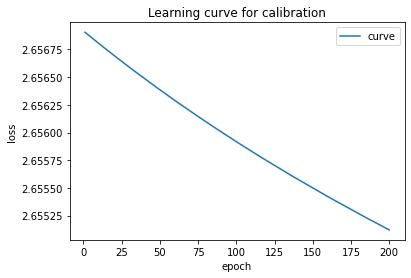

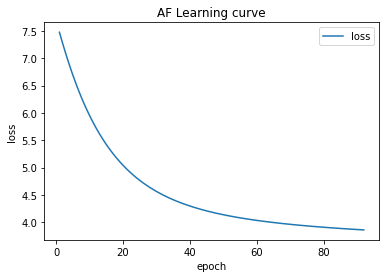

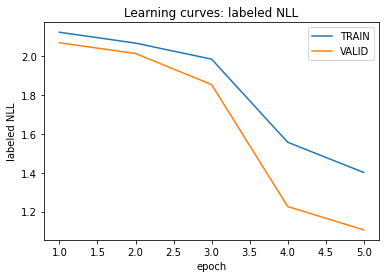

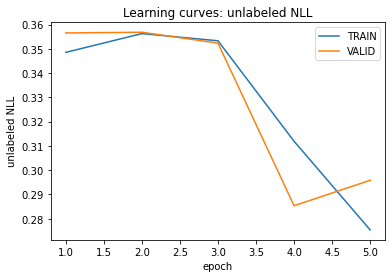

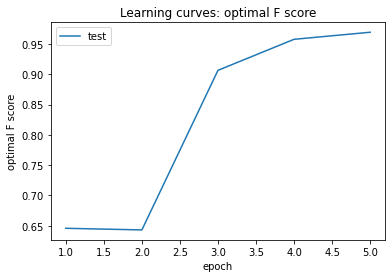

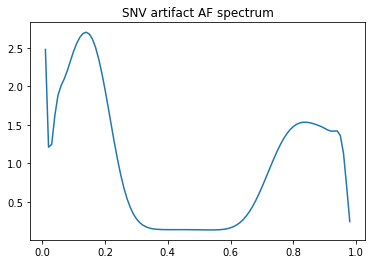

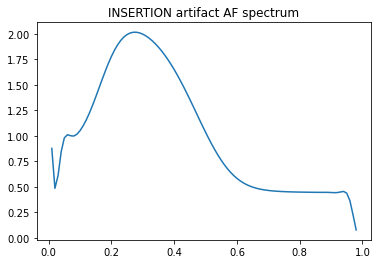

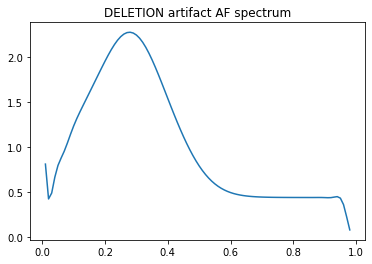

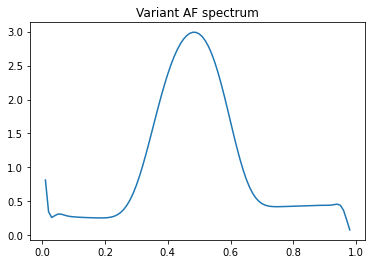

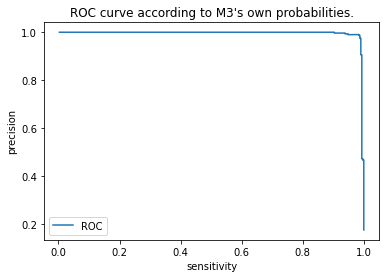

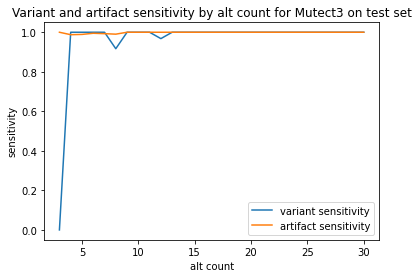

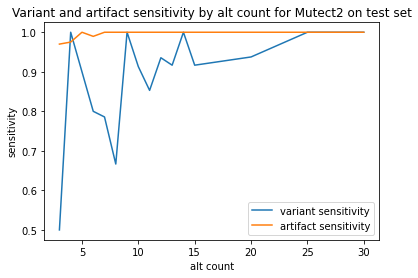

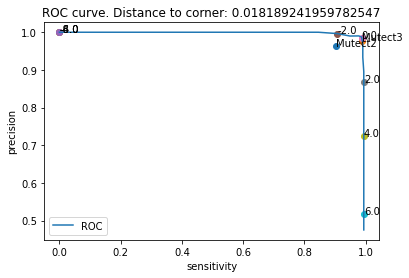

In [3]:
beta1 = Beta(5,1)
beta2 = Beta(5,1)
batch_size = 64
num_epochs = 5
params = train.TrainingParameters(batch_size, num_epochs, beta1, beta2)

hidden_read_layers = [20,20]
hidden_info_layers = [20,20]
aggregation_layers = [20]
output_layers = [10]
dropout_p = 0.2
m3_params = networks.Mutect3Parameters(hidden_read_layers, hidden_info_layers, aggregation_layers, output_layers, dropout_p)

trained_model = train.run_evaluation([DREAM_1_SMALL_PAIR], DREAM_1_SMALL_TEST, params, m3_params)